<a href="https://colab.research.google.com/github/manthanawgan/MLops/blob/main/Duration_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error


In [2]:
pd.__version__

'2.2.2'

In [13]:
df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-01.parquet")

In [43]:
df.shape

(3403248, 21)

In [44]:
df.dtypes

,0
VendorID,int32
tpep_pickup_datetime,datetime64[us]
tpep_dropoff_datetime,datetime64[us]
passenger_count,float64
trip_distance,float64
RatecodeID,float64
store_and_fwd_flag,object
PULocationID,int32
DOLocationID,int32
payment_type,int64


In [52]:
df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)

In [53]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td : td.total_seconds() / 60)

In [54]:
df.duration.describe(percentiles = [0.99, 0.98, 0.95] )

,duration
count,3.403248e+06
mean,1.422852e+01
std,9.763400e+00
min,1.000000e+00
50%,1.171667e+01
95%,3.416667e+01
98%,4.401667e+01
99%,5.008333e+01
max,6.000000e+01


In [36]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [50]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

df[categorical].dtypes

,0
PULocationID,object
DOLocationID,object


In [67]:
train_dicts = df[categorical + numerical].to_dict(orient ='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
root_mean_squared_error(y_train, y_pred)

7.720556933452069

<ipython-input-70-5fdabbf3bec2>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
<ipython-input-70-5fdabbf3bec2>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


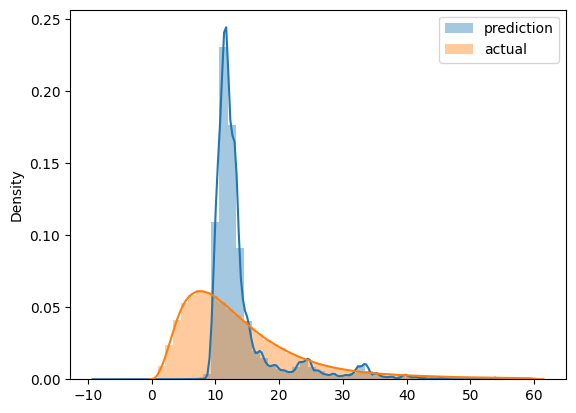

In [70]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()